In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
from itertools import product
import GPyOpt

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import torch
from torch import Tensor
from torch import Tensor as T
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.optim
from torch.optim import SGD
import torch.nn.functional as F

import keras
L = keras.layers

import sys
sys.path.append('../code')

import toy_data as toy
from vae import VAE, loss_function, cVAE, fit
import vae as v

from sklearn import gaussian_process

from tqdm_utils import TqdmProgressCallback
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm

from contextlib import ExitStack
from functools import partial

from IPython.core.debugger import set_trace

# from notebook_utils import *
import notebook_utils as nu

# import GPyOpt

# Some parameters:
N = 3600000  # number of observations
batch_size = 128
d = 64  # image edge length
D = d**2
img_shape = (d, d)
latent_dim = 4
print(f"{N} points with {D} dimensions.")

from functools import partial
plot_sample_grid = partial(nu.plot_sample_grid, img_shape=img_shape)

# don't forget to start visdom!
plotter = nu.VisdomLinePlotter(env_name='main')

# setting up torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

3600000 points with 4096 dimensions.
Pytorch: Train with cuda


# Toy data: Images of hierarchical structures without time dependency

Generate (d, d)-pixel images from 7 parameters: 
- 3 angles for each image, 
- 3 bone lengths and keypoint marker width shared for whole dataset. 

Origin of the 3-bone hierarchy is the central pixel.
End of bones are marked by squared exponentials.

In [9]:
# parameters:
eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32

labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4),
              'pretrain': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//5)),
                               drop_last=True, batch_size=batch_size, num_workers=4)
             }

# dataloader with size comparable of PCA's datasize limit
subsets = {k: Subset(h, np.random.choice(range(len(v)), size=5000)) for k, v in zip(['train', 'val'], [h, h_val])}
reduced_dataloader = {k: DataLoader(subsets[k], batch_size=batch_size, drop_last=True) for k in subsets}

# generate, encode, and decode new image for validation
idx = np.random.randint(0, len(h_val))
test_img = h_val[idx]['image']
test_angles = h_val[idx]['angles']

Bone lengths: [9.78408279 7.68606698 7.11303128]


### Example: See end of notebook for video!

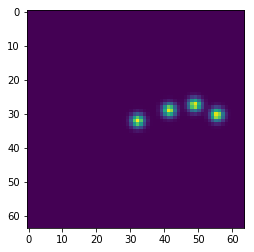

In [134]:
h.plot_image(np.random.randint(0, len(labels)))

## PCA

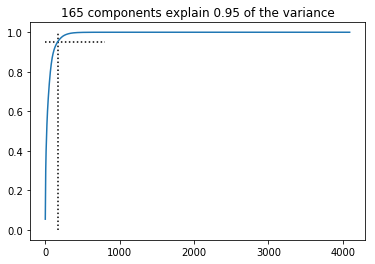

In [4]:
# Use subset of data because of memory restriction
idxs = np.random.choice(range(len(h)), replace=False, size=D)
imgs = np.array([h[i]['image'] for i in idxs])
X = np.reshape(imgs, (len(idxs), d**2))
pca = PCA().fit(X)
# n_comp = pca.n_components

vexpl = np.cumsum(pca.explained_variance_ratio_)
plt.plot(vexpl)
thresh = 0.95
n_comp = np.where(vexpl > thresh)[0][0]
plt.vlines(n_comp, 0, 1, linestyles='dotted')
plt.hlines(thresh, 0, 800, linestyles='dotted')
plt.title(f'{n_comp} components explain {thresh} of the variance')
plt.show()

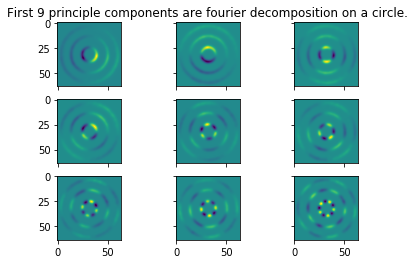

In [6]:
# Plot first 9 components
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
ax[0, 1].set_title('First 9 principle components are fourier decomposition on a circle.')
for i in range(9):
    x, y = nu.to_ind[i]
    comp = pca.components_[i].reshape(img_shape)
    ax[x, y].imshow(comp)
# plt.tight_layout()
plt.show()

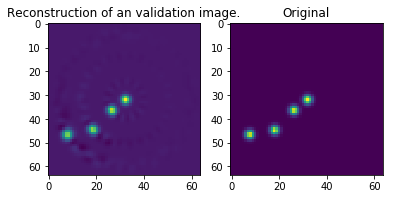

In [8]:
w = pca.transform(test_img.ravel()[None])[:, :n_comp]

recon_img = np.dot(w, pca.components_[:n_comp])[0].reshape(*img_shape)
recon_img = recon_img + pca.mean_.reshape(*img_shape)
nu.plot_reconstruction(recon_img, test_img)

In [9]:
# dataloader = {'train': data_loader,
#               'val': val_loader}

loss = {}
loss_pp = {}
for phase in reduced_dataloader.keys():
    loss[phase] = []
    for data in tqdm(reduced_dataloader[phase]):
        original = data['image'].view(-1, D).cpu().detach().numpy()
        w = pca.transform(original)[:, :n_comp]
        recon_img = np.dot(w, pca.components_[:n_comp])
        loss[phase] += [(recon_img - original)**2]
    loss_pp[phase] = np.mean(np.array(loss[phase]))
    
for k in reduced_dataloader.keys():
    print(f'PCA {k} loss: {loss_pp[k]}')


PCA train loss: 0.0016434049822786072
PCA val loss: 0.0016420644450864264


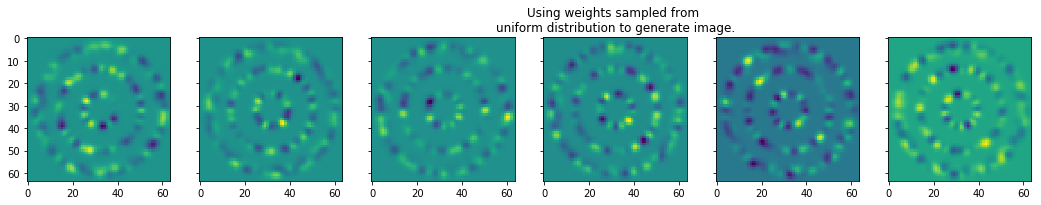

In [10]:
# generate image from noise
W = pca.transform(X)[:, :n_comp]

# Using uniform noise because it matches the
# statistics of w better than gauss

min_w = W.min(axis=0)
span = W.max(axis=0) - min_w

n_examples = 6
eps = np.random.rand(n_examples, n_comp)
w_rand = span[None] * eps + min_w[None]

generated = np.dot(w_rand, pca.components_[:n_comp])

fig, ax = plt.subplots(ncols=n_examples, sharey=True)
fig.set_size_inches(n_examples*3, 3)
ax[n_examples//2].set_title('Using weights sampled from \nuniform distribution to generate image.')
for i in range(n_examples): 
    ax[i].imshow(generated[i].reshape(*img_shape))
plt.show()

# Linear Autoencoder (PCA) and MLP Autoencoder

In [6]:
class LinearAutoencoder(nn.Module):
    def __init__(self, code_size=10):
        nn.Module.__init__(self)
        self.encoder = nn.Linear(D, code_size)
        self.decoder = nn.Linear(code_size, D)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, h):
        return self.decoder(h)
    
    def forward(self, x):
        w = self.encode(x.view(-1, D))
        return self.decode(w)
    
class MLPAutoencoder(nn.Module):
    def __init__(self, code_size=10, hidden=40):
        nn.Module.__init__(self)
        self.encoder = nn.ModuleList([
            nn.Linear(D, hidden),
            nn.Linear(hidden, code_size),
            nn.Linear(D, code_size)
        ])
        self.decoder = nn.ModuleList([
            nn.Linear(code_size, hidden),
            nn.Linear(hidden, D),
            nn.Linear(code_size, D)
        ])
    
    def encode(self, x):
        # h = F.relu(self.encoder[0](x))
        # return F.relu(self.encoder[1](h))
        return F.relu(self.encoder[2](x))
    
    def decode(self, latent):
        #h = F.relu(self.decoder[0](latent))
        #return F.tanh(self.decoder[1](h))
        return F.tanh(self.decoder[2](latent))
    
    def forward(self, x):
        w = self.encode(x.view(-1, D))
        return self.decode(w)

In [7]:
n_comp = 1000
la = LinearAutoencoder(code_size=n_comp)
la = MLPAutoencoder(code_size=n_comp)
la.to(device)

optimizer = torch.optim.Adam(la.parameters(), lr=1e-3)

train_losses = {}
for epoch in range(1):
    for phase in ['train', 'val']:
        train_losses[phase] = []
        with ExitStack() as stack:
            pbar = stack.enter_context(tqdm(dataloader[phase], leave=True))
            if phase == 'val':
                stack.enter_context(torch.no_grad())
                
            i = -1
            for batch in pbar:
                i += 1
                data = batch['image'].float().to(device)
                recon = la(data.view(-1, D))
                l = torch.mean((recon - data.view(-1, D))**2)
                if phase == 'train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                train_losses[phase].append(l.cpu().detach().numpy())
                pbar.set_description(f'({phase}) Epoch {epoch}: MSE = {l:.5f}')
                
                if i % 20 == 0:
                    plotter.plot_image('recon', recon)
                    plotter.plot_image('orig', data)
        print(phase, np.mean(train_losses[phase]) if phase =='val' else train_losses[phase][-1])

# plt.plot(train_losses)
# plt.show()


train 2.800746e-05



val 2.9610523e-05


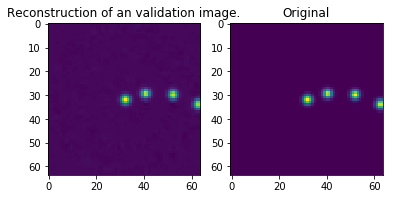

In [8]:
recon = la(Tensor(test_img).view(-1, D).to(device)).cpu().detach().numpy().reshape(img_shape)
nu.plot_reconstruction(recon, test_img)

## Variational Autoencoder

### Bernoulli observation model

In [46]:
# These parameters are not optimized yet
latent_dim = 3
hidden = 600
beta = 1

model = VAE(input_dim=D, latent_dim=latent_dim,
            hidden=hidden).to(device)

loss_func = partial(v.loss_function, likelihood='bernoulli')
val_loss = fit(model, dataloader, epochs=3, device=device, beta=beta, stop_crit=0, plotter=plotter)


train loss: 1.70E-06
val loss: 1.96E-03



train loss: 1.50E-06
val loss: 1.71E-03



train loss: 1.38E-06
val loss: 1.60E-03


The plots show $p(x|z)$ with $z \sim \mathcal{N}(0, 1)$.
Even though there is room for improvement (e.g. changing the output activation function), I think the network learned the hierarchical constraints.

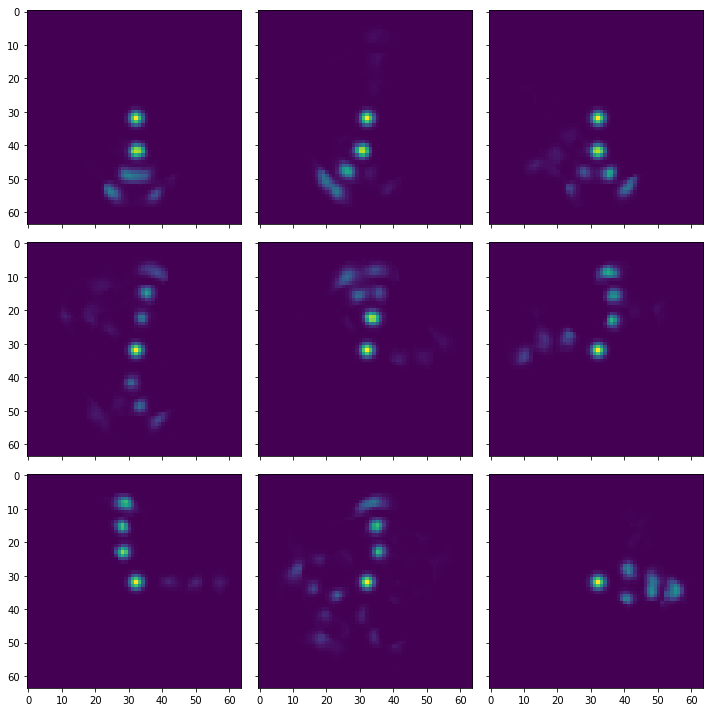

In [48]:
plot_sample_grid(nu.draw_samples(model))

### Traversing the latent space

Maybe the 3 latent dimensions correspond to the angles already?
$\rightarrow$ Not quite...

In [49]:
mu_lat = np.zeros((1, latent_dim))
mu_np = mu_lat
model.to(device)
def get_img(ind):
    # mu_np = mu_lat.cpu().detach().numpy()
    fig, ax = plt.subplots()
    for x in np.linspace(-4, 4):
        mu_np[:, ind] = x
        mu_star = Tensor(mu_np).to(device)
        gen = model.decode(mu_star)[0]
        gen = gen.cpu().detach().numpy().reshape(img_shape)
        yield (x, gen)

fig, ax = plt.subplots()
img = h[0]['image']

mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(img):
    x, img = img
    ax.set_title(f'{x:.3}')
    mimg.set_data(img)
    return (mimg,)

In [50]:
vids = []
for i in range(mu_lat.shape[1]):
    g = get_img(i)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=g, interval=120, 
                                   blit=True)
    vids += [anim.to_html5_video()]
    plt.close()

In [51]:
HTML(vids[0])

In [52]:
HTML(vids[1])

In [53]:
HTML(vids[2])

## Gaussian observation model

Two things are required to make Gaussian VAE work with toydata:

- PCA Trick: use weights of PCA as input
- use optimized weight $\beta$ for $\mathcal{KL}(q(z|x) || p(z))$ Term


pretrain loss: 8.01E-03



train loss: 3.52E-06
val loss: 4.41E-03



train loss: 3.05E-06
val loss: 3.71E-03



train loss: 2.84E-06
val loss: 3.50E-03


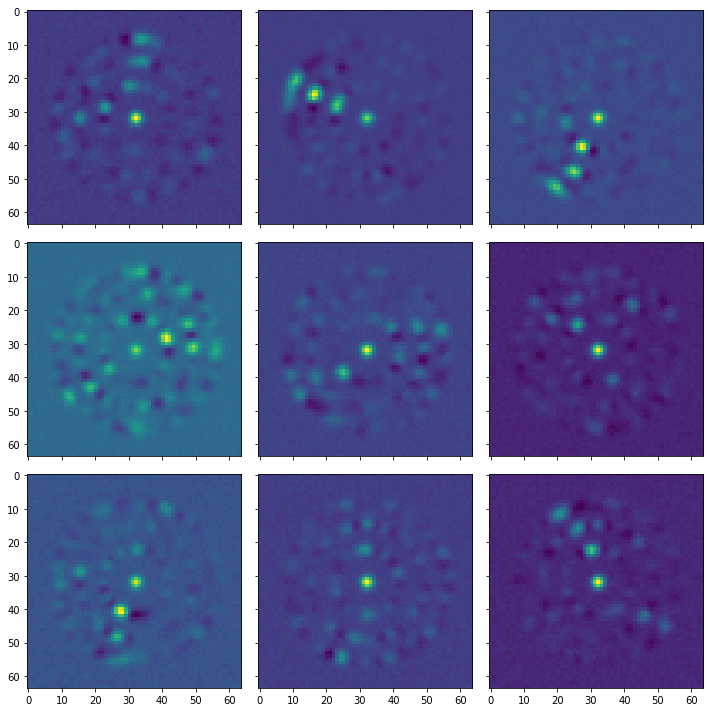

In [17]:
# following parameters have been found by GPyOpt for Gaussian VAE:
latent_dim = 8
hidden = 283
beta = 0.89
pca_dim = 525

continue_training = False
if continue_training:
    model.to(device)
else:
    model = VAE(input_dim=D, latent_dim=latent_dim, pre_dim=pca_dim,
                hidden=hidden, likelihood='normal').to(device)
    

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_func = partial(v.loss_function, beta=1, likelihood=model.likelihood)
loss_func = v.joint_loss

# model.to(device)
save_weights = False
weight_fn = 'gaussianVAEweights.pt' if save_weights else None

# N = 15000
dataloader = {'train': DataLoader(Subset(h, np.random.choice(range(len(h)), size=N)), num_workers=4,
                                 drop_last=True, batch_size=batch_size),
              'val': DataLoader(Subset(h_val, np.random.choice(range(len(h_val)), size=N//40)),
                               drop_last=True, batch_size=batch_size),
              'pretrain': DataLoader(Subset(h, np.random.choice(range(len(h_val)), size=N)),
                               drop_last=True, batch_size=batch_size)
             }
# reduced_dataloader['pretrain'] = DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
#                            drop_last=True, batch_size=batch_size)

val_loss = fit(model, dataloader, device=device,
                epochs=3, loss_func=v.joint_loss, weight_fn=weight_fn,
                plotter=plotter, stop_crit=0, beta=beta)

plot_sample_grid(nu.draw_samples(model))

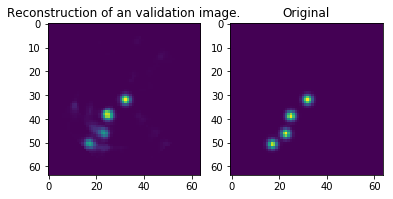

In [22]:
model.to('cpu')
test_input = test_img.ravel()[None]
img_param, latent_param, pose_param, pre_param = model(Tensor(test_input).to('cpu'), pose=None)
mu = img_param['mean'].cpu().detach().numpy().reshape(img_shape)
nu.plot_reconstruction(mu, test_img)

The Gaussian VAE results still don't seem as good. Maybe I should just stick to mixing Bernoulli and Gaussian observations for images and pose.

## Conditional VAE

In [69]:
save_weights = False
weight_fn = 'cvae_weights.pt' if save_weights else None
latent_dim = 3
beta = 0.89

save_weights = False
weight_fn = 'cvae_weights.pt' if save_weights else None

# torch.save(cvae.state_dict(), weight_fn)
# cvae.load_state_dict(torch.load(weight_fn))

cvae = cVAE(input_dim=D, latent_dim=latent_dim, pose_dim=3, hidden=600, likelihood='bernoulli').to(device)

loss_func = partial(v.joint_loss, likelihood='bernoulli')
hist = fit(cvae, dataloader, epochs=8, device=device, weight_fn=weight_fn,
           loss_func=loss_func,
           conditional=True, plotter=plotter, stop_crit=0, beta=beta)


train loss: 2.09E-06
val loss: 2.52E-03



train loss: 1.56E-06
val loss: 1.92E-03



train loss: 1.56E-06
val loss: 1.84E-03



train loss: 1.30E-06
val loss: 1.57E-03



train loss: 1.27E-06
val loss: 1.53E-03



train loss: 1.06E-06
val loss: 1.32E-03



train loss: 1.25E-06
val loss: 1.45E-03



train loss: 1.04E-06
val loss: 1.26E-03


## Generating images given labels

It should be possible to generate images from noise conditioned on label. 
Even though conditioning removes some of the noise, it does not yet replicate
the label.

In [131]:
# plt.imshow(test_img)
idxs = np.random.choice(range(len(h_val)), size=9)
labels = np.array([h_val[i]['angles'] for i in idxs])
samples = nu.draw_samples(cvae, labels)
imgs = np.array([h_val[i]['image'] for i in idxs])
# labels, samples[:, D:]

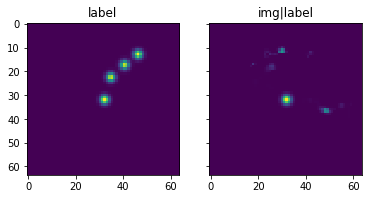

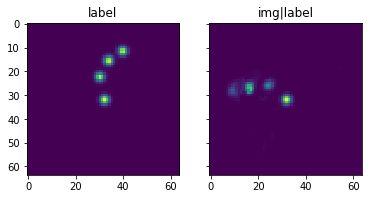

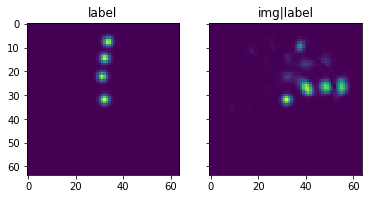

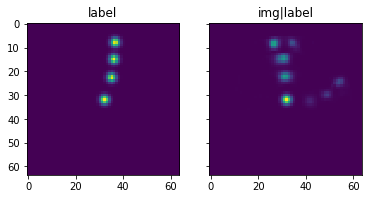

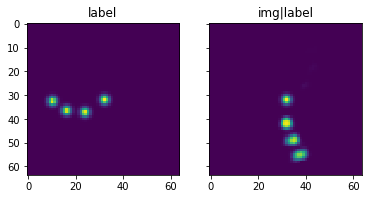

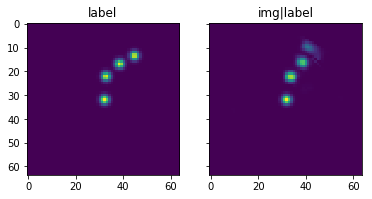

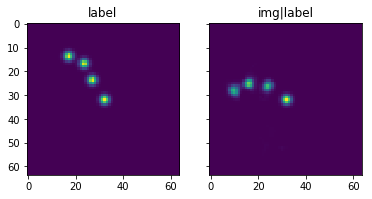

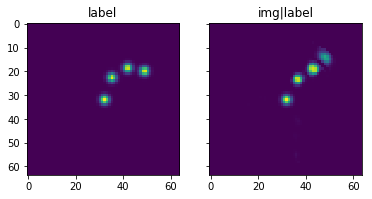

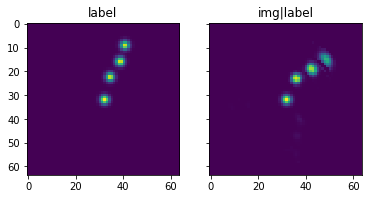

In [132]:
for i in range(9):
    label = samples[i, D:]
    img = samples[i, :D]
    fig, ax = plt.subplots(ncols=2, sharey=True)
    ax[0].set_title('label')
    ax[0].imshow(imgs[i])
    ax[1].set_title('img|label')
    ax[1].imshow(img.reshape(d, d))
    plt.show()

# Toy data: Adding time dependency

If the VAE works well enough on simple, unambiguous single frame toy data, a VAE with recurrent latent space should be able to tackle ambigous data.

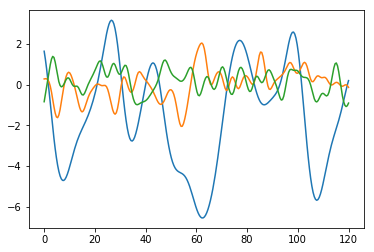

In [54]:
# introduce time dependency
rbf = gaussian_process.kernels.RBF(length_scale=2)
rbf_slow = gaussian_process.kernels.RBF(length_scale=5)
GP = gaussian_process.GaussianProcessRegressor(kernel=rbf)
GP_slow = gaussian_process.GaussianProcessRegressor(kernel=rbf_slow)

N = 250
t = np.linspace(0, 120, N)
y = np.empty((N, len(bone_lengths)))
y[:, 0] = GP_slow.sample_y(t[:, None], random_state=None)[:, 0]*3
for i in range(1, len(bone_lengths)):
    y[:, i] = GP.sample_y(t[:, None], random_state=None)[:, 0]*0.7
labels = y
plt.plot(t, labels)

# angles can not escape [-np.pi, np.pi]
idx = abs(y) > np.pi
y[idx] = y[idx] - 2*np.sign(y[idx])*np.pi

In [55]:
h = toy.HierarchyImages(labels, bone_lengths, key_marker_width=key_marker_width, img_shape=img_shape)
imgs = [h[i]['image'] for i in range(len(labels))]

In [56]:
fig, ax = plt.subplots()
img = imgs[0]
mimg = plt.imshow(img)
plt.close()

def init():
    mimg.set_data(img)
    return (mimg,)

def animate(i):
    img = imgs[i]
    mimg.set_data(img)
    return (mimg,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(imgs), interval=60, 
                               blit=True)
# anim.save(f'Toyproblem_unambiguous_{d}x{d}.mp4')
html_video = anim.to_html5_video()

In [57]:
HTML(html_video)